## Part 1

In [24]:
from data_rnn import load_imdb
import matplotlib.pyplot as plt
import numpy as np
from time import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [3]:
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=False)

In [4]:
print([i2w[w] for w in x_train[141]])

['possibly', 'the', 'best', 'movie', 'ever', 'created', 'in', 'the', 'history', 'of', 'jeffrey', 'combs', 'career', 'and', 'one', 'that', 'should', 'be', 'looked', 'upon', 'by', 'all', 'talent', 'in', 'hollywood', 'for', 'his', 'versatility', 'charisma', 'and', 'uniqueness', 'he', 'brings', 'through', 'his', 'characters', 'and', 'his', 'knowledge', 'of', 'acting']


In [5]:
print([i2w[w] for w in x_train[0]])

['this', 'movie', 'is', 'terrible', 'but', 'it', 'has', 'some', 'good', 'effects']


In [6]:
x_train[0]

[14, 19, 9, 379, 22, 11, 50, 52, 53, 290]

In [7]:
x_train[1]

[13, 574, 25, 809, 14, 32, 63, 26, 2722, 2231, 312]

### Question 1

In [8]:
embedding_dim = 300
hidden_size = 300
batch_size = 128
padding_idx = w2i['.pad']
num_embeddings = len(w2i)

In [9]:
class MLP(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx, hidden_size, output_size) -> None:
        super().__init__()

        self.embed = nn.Embedding(num_embeddings, embedding_dim, padding_idx) # [batch_size, time] -> [batch_size, time, embedding_dim]
        self.linear1 = nn.Linear(embedding_dim, hidden_size) # [batch_size, time, embedding_dim] -> [batch_size, time, hidden_size]
        self.linear2 = nn.Linear(hidden_size, output_size) # [batch_size, hidden_size] -> [batch_size, output_size]

    def forward(self, input):
        x = input

        x = self.embed(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = torch.max(x, dim=1, keepdim=True).values.squeeze()
        x = self.linear2(x)
        
        return x

In [10]:
mlp = MLP(num_embeddings, embedding_dim, padding_idx, hidden_size, output_size=numcls)
mlp

MLP(
  (embed): Embedding(99430, 300, padding_idx=0)
  (linear1): Linear(in_features=300, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=2, bias=True)
)

In [11]:
def batch_length(batch):
    return max(len(seq) for seq in batch)

In [12]:
batch = x_train[:5]
batch_length(batch)

15

In [13]:
batch_length(x_train)

2514

In [14]:
def add_padding(seq, amt=1):
    for _ in range(amt):
        seq.append(w2i['.pad'])
    return seq

In [15]:
def add_start(seq):
    seq.insert(0, w2i['.start'])
    return seq

In [16]:
def add_end(seq):
    seq.append(w2i['.end'])
    return seq

In [17]:
def preprocess_batch(batch, targets):
    max_len = batch_length(batch)
    
    upd_batch = []
    for i, _ in enumerate(batch):
        seq = batch[i].copy()
        seq = add_start(seq)
        seq = add_end(seq)
        seq = add_padding(seq, amt=max_len + 2 - len(seq))
        upd_batch.append(seq)
    
    upd_batch = torch.tensor(upd_batch, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    
    return upd_batch, targets

In [18]:
def batch_generator(data, targets, batch_size=128):
    data = np.array(data)
    targets = np.array(targets)

    indx = np.random.permutation((len(data)))
    n_batches = int(len(data) / batch_size) + 1

    for i in range(n_batches):
        bound_l = batch_size*i
        bound_r = batch_size*(i+1) if i + 1 < n_batches else len(indx)

        batch_ind = indx[bound_l:bound_r]
        batch = data[batch_ind]

        yield preprocess_batch(batch, targets[batch_ind])


In [19]:
batch_t, target_t = preprocess_batch(x_train[:5], y_train[:5])
batch_t, target_t

(tensor([[    1,    14,    19,     9,   379,    22,    11,    50,    52,    53,
            290,     2,     0,     0,     0,     0,     0],
         [    1,    13,   574,    25,   809,    14,    32,    63,    26,  2722,
           2231,   312,     2,     0,     0,     0,     0],
         [    1, 10721,     4, 10956,   129,     6,   124, 88114,     5,     6,
             19,    93,  4118,     2,     0,     0,     0],
         [    1,   198,   351, 17697,   116,    31,    13,    80,    40,  1240,
              8,    69,   272,   883,  1749,     2,     0],
         [    1,    60,   913,   366,    19,   118,   836,    44,   431,   902,
             60,   286,    35,    34,  1834,    11,     2]]),
 tensor([1, 1, 1, 1, 1]))

In [20]:
mlp(batch_t)

tensor([[ 0.1154, -0.0898],
        [-0.1106, -0.0324],
        [ 0.2011,  0.0102],
        [ 0.6439, -0.1069],
        [ 0.3768,  0.0097]], grad_fn=<AddmmBackward0>)

### Question 2

In [21]:
def train(mlp, x_train, y_train, x_val, y_val, epochs=10, batch_size=128, learning_rate=0.001):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

    metrics = {
        'loss_history': [],
        'loss_train': [],
        'loss_val': [],
        'acc_val': []
    }
    for epoch in range(epochs):
        running_loss = 0.0
        total_loss = 0.0

        mlp.train()
        for i, (x_batch, y_batch) in enumerate(batch_generator(x_train, y_train, batch_size)):
            start_time = time()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = mlp(x_batch)
            # outputs = outputs.softmax(dim=-1) # The input is expected to contain the unnormalized logits for each class
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            finish_time = time()

            # print statistics
            running_loss += loss.item()
            total_loss += loss.item()
            if i % 20 == 19:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f} time: {finish_time - start_time:.3f}')
                metrics['loss_history'].append(running_loss / 20)
                running_loss = 0.0
        metrics['loss_train'].append(total_loss / len(x_train))

        mlp.eval()

        correct = 0
        total = 0
        for i, (x_batch, y_batch) in enumerate(batch_generator(x_val, y_val, batch_size)):
            outputs = mlp(x_batch)
            outputs = outputs.softmax(dim=-1)
            loss = criterion(outputs, y_batch)
            _, predicted = torch.max(outputs, -1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            metrics['loss_val'].append(loss.item())

        metrics['acc_val'].append(correct / total)

        print(f'Accuracy of the network on the {total} text: {100 * correct // total} %')

    return metrics

In [22]:
mlp = MLP(num_embeddings, embedding_dim, padding_idx, hidden_size, output_size=numcls)
metrics = train(mlp, x_train, y_train, x_val, y_val, epochs=5, batch_size=128, learning_rate=0.001)

/var/folders/dh/hnfk1d0900xb0k9kt9scz8680000gn/T/ipykernel_29877/1902260606.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


[1,    20] loss: 0.655 time: 0.849
[1,    40] loss: 0.572 time: 0.984
[1,    60] loss: 0.529 time: 1.405
[1,    80] loss: 0.510 time: 0.837
[1,   100] loss: 0.486 time: 0.765
[1,   120] loss: 0.473 time: 0.877
[1,   140] loss: 0.465 time: 0.886
Accuracy of the network on the 5000 text: 85 %
[2,    20] loss: 0.431 time: 0.850
[2,    40] loss: 0.434 time: 0.741
[2,    60] loss: 0.433 time: 0.764
[2,    80] loss: 0.430 time: 0.708
[2,   100] loss: 0.427 time: 0.794
[2,   120] loss: 0.437 time: 0.557
[2,   140] loss: 0.430 time: 1.053
Accuracy of the network on the 5000 text: 87 %
[3,    20] loss: 0.401 time: 0.746
[3,    40] loss: 0.393 time: 0.787
[3,    60] loss: 0.398 time: 0.764
[3,    80] loss: 0.396 time: 0.859
[3,   100] loss: 0.396 time: 0.552
[3,   120] loss: 0.404 time: 0.759
[3,   140] loss: 0.405 time: 0.776
Accuracy of the network on the 5000 text: 88 %
[4,    20] loss: 0.372 time: 0.586
[4,    40] loss: 0.371 time: 0.761
[4,    60] loss: 0.365 time: 0.832
[4,    80] loss: 0.

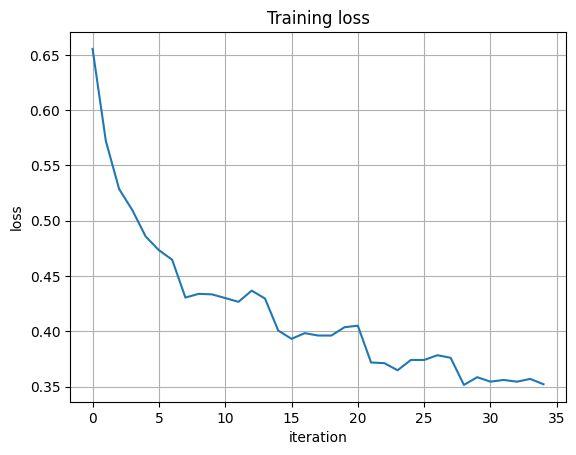

In [26]:
plt.plot(metrics['loss_history'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.title('Training loss')
plt.show()

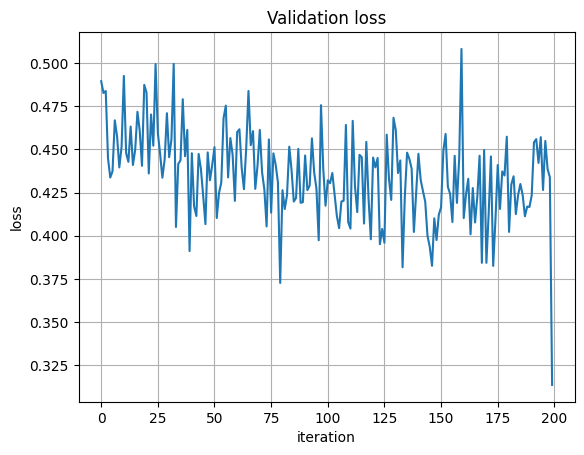

In [28]:
plt.plot(metrics['loss_val'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.title('Validation loss')
plt.show()

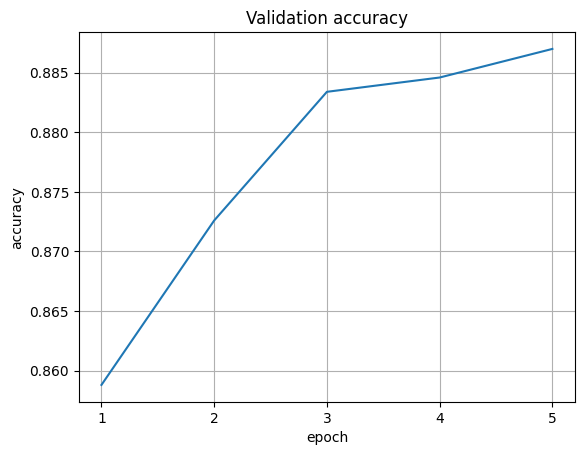

In [31]:
plt.plot(range(1, 6), metrics['acc_val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.xticks(range(1, 6))
plt.title('Validation accuracy')
plt.show()